## Data Explanation

The dataset was accessed from a preprint pubplication by radiologists from Tongji Hospital in Wuhan, China, who confirmed its usefulness despite some concerns about image quality degradation and the selection of only a few key slices from the original CT scans. Data access: https://github.com/UCSD-AI4H/COVID-CT

## Data Pre-processing and Features Extraction

In [ ]:
#Packages and working directory Setup
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import os

#os.chdir('drive/MyDrive/Images')

In [ ]:
# Set the paths for the positive and negative CT scans
positive_dir = "CT_COVID"
negative_dir = "CT_NonCOVID"
# Set the output directory for the preprocessed images
output_dir = "Preprocess_Output"

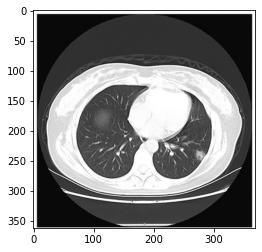

In [ ]:
#check the validity of the images in the directory
img = cv2.imread("CT_COVID/PIIS0140673620303603%8.png")
plt.imshow(img)
plt.show()

In [ ]:
#Resize
img_size = (224, 224)

# Load the positive CT scans
for filename in os.listdir(positive_dir):
    img_path = os.path.join(positive_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    output_path = os.path.join(output_dir, f"COVID_{filename}")
    cv2.imwrite(output_path, img)

# Load the negative CT scans
for filename in os.listdir(negative_dir):
    img_path = os.path.join(negative_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    output_path = os.path.join(output_dir, f"NonCOVID_{filename}")
    cv2.imwrite(output_path, img)

In [ ]:
# Set the output directory for the extracted features
features_dir = "Features"


In [ ]:
# Load the ResNet50 model and remove the classification layer
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
# Extract features from the preprocessed images
for filename in os.listdir(output_dir):
    img_path = os.path.join(output_dir, filename)
    img = cv2.imread(img_path)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    features_path = os.path.join(features_dir, f"{filename}.npy")
    np.save(features_path, features)

1/1 [==============================] - 0s 194ms/step


## Model Initiation and Data Split 

In [ ]:
# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


In [ ]:
# Load the extracted features and labels
features = []
labels = []

In [ ]:
for filename in os.listdir(features_dir):
    features_path = os.path.join(features_dir, filename)
    feature = np.load(features_path)
    features.append(feature)
    
    if filename.startswith("COVID"):
        label = 1
    else:
        label = 0
    labels.append(label)

In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
# Split the data into training, validation, and test sets
train_idx = np.random.choice(range(len(features)), int(0.8*len(features)), replace=False)
temp_idx = list(set(range(len(features))) - set(train_idx))
val_idx = np.random.choice(temp_idx, int(0.1*len(features)), replace=False)
test_idx = list(set(temp_idx) - set(val_idx))

In [ ]:
train_X, train_y = features[train_idx], labels[train_idx]
val_X, val_y = features[val_idx], labels[val_idx]
test_X, test_y = features[test_idx], labels[test_idx]

In [ ]:
#adjust the shapes to be appropiate for XGBoost training (should be 2 dimensional)
train_X = train_X.reshape(train_X.shape[0], -1)
val_X = val_X.reshape(val_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
features = features.reshape(features.shape[0], features.shape[2])

## Training the Model

In [ ]:
# Train the XGBoost model
dtrain = xgb.DMatrix(train_X, label=train_y)
dval = xgb.DMatrix(val_X, label=val_y)

watchlist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)


[0]	train-logloss:0.629141	eval-logloss:0.669027
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.299067	eval-logloss:0.53258
[20]	train-logloss:0.163065	eval-logloss:0.462459
[30]	train-logloss:0.100827	eval-logloss:0.431703
[40]	train-logloss:0.068531	eval-logloss:0.415355
[50]	train-logloss:0.050737	eval-logloss:0.403657
[60]	train-logloss:0.039283	eval-logloss:0.397981
[70]	train-logloss:0.031943	eval-logloss:0.386105
[80]	train-logloss:0.026797	eval-logloss:0.390808
[90]	train-logloss:0.02296	eval-logloss:0.384648
[100]	train-logloss:0.020205	eval-logloss:0.385222
[110]	train-logloss:0.018057	eval-logloss:0.38533
[120]	train-logloss:0.016329	eval-logloss:0.383079
[130]	train-logloss:0.01487	eval-logloss:0.377011
[140]	train-logloss:0.013622	eval-logloss:0.379936
Stopping. Best iteration:
[129]	train-logloss:0.014996	eval-logloss:0.376555



## Predictions and Performance Mertices

In [ ]:
# Evaluate the model on the test set
dtest = xgb.DMatrix(test_X, label=test_y)
preds = model.predict(dtest)
pred_labels = np.round(preds)

accuracy = accuracy_score(test_y, pred_labels)
precision = precision_score(test_y, pred_labels)
recall = recall_score(test_y, pred_labels)
f1 = f1_score(test_y, pred_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Accuracy: 0.75
Precision: 0.7777777777777778
Recall: 0.717948717948718
F1 score: 0.7466666666666666


## Visualization 


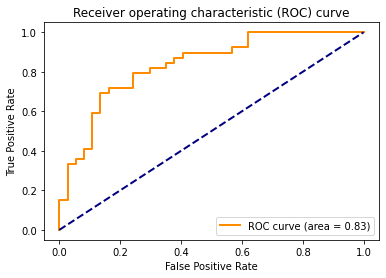

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, preds)
roc_auc = roc_auc_score(test_y, preds)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


**Visualization Interpretation** :
*   AUC of 0.83 means that the model is able to correctly classify 83% of the positive samples while keeping the false positive rate (FPR) low. This indicates that the model is able to effectively separate the two classes, and is likely to perform well on other unseen data.

## References

Yang, X., He, X., Zhao, J., Zhang, Y., Zhang, S., & Xie, P. (2020). COVID-CT-dataset: a CT scan dataset about COVID-19. arXiv preprint arXiv:2003.13865.

Chen, T., & Guestrin, C. (2016). XGBoost. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. https://doi.org/10.1145/2939672.2939785

